## Simple Moving Average(SMA) Cross-over Algorithmic Trading Strategy

## Aim:
1. To implement simple moving average crossover algorithmic trading strategy, backtesting, evaluate performance locally using data set from Quandl.
2. To implement same investment strategy in Quantopian. Also **backtest and perform live paper trading and evaluate performance**.


### Table of Contents
1. [Fetch stock data](1.-Fetch-stock-data)
2. [Formulate a momentum strategy - Simple Moving Avg cross-over Strategy](#2.-Formulate-SMA-strategy)
3. [Visualize moving averages and cross-over points](#3.-Visualize-moving-averages-and-cross-over-points)
4. [Backtesting the SMA cross-over strategy locally](#4.-Backtesting-the-SMA-cross-over-strategy-locally)
5. [Visualizing portfolio constructed during backtesting using SMA cross-over strategy](#5.-Visualizing-portfolio-constructed-during-backtesting-using-SMA-cross-over-strategy)
6. [Evaluating performance of SMA cross-over strategy](#6.-Evaluating-performance-of-SMA-cross-over-strategy)
  1. [Sharpe Ratio](#A.-Sharpe-Ratio)
  2. [Compound Annualized Growth Rate(CAGR)](#B.-Compound-Annualized-Growth-Rate---CAGR)
7. [**Implementing SMA Algorithm in Quantopian**](#7.-Implementing-SMA-Algorithm-in-Quantopian)
8. [**Backtest SMA strategy on Quantopian**](#8.-Backtest-SMA-strategy-on-Quantopian)  
9. [**Backtesting - Performance Results**](#9.-Backtesting---Performance-Results)

In [27]:
import pandas as pd
import quandl
import datetime
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### 1. Fetch stock data

In [28]:
def get_data(ticker, start_date, end_date, csv_file_name):
    if os.path.exists(csv_file_name):
        all_data = pd.read_csv(csv_file_name,  index_col=['Date'], header =0, parse_dates=True)
        print("Read tickers data from file:", csv_file_name)
        return all_data
    else:
        quandl.ApiConfig.api_key = "CG7axqyftyamjMa2DPB5"
        ticker_data = quandl.get('WIKI/'+ticker, start_date = start_date, end_date = end_date)
        ticker_data.to_csv(csv_file_name)
        return ticker_data

### 2. Formulate SMA strategy

In [29]:
short_lookback_period = 40 # days
long_lookback_period = 100 # days

apple_ticker_data = get_data('AAPL', '2006-10-01', '2012-01-01', "apple_ticker_data.csv")

# Prepare a signal dataframe with Date same as from apple ticker data
signals = pd.DataFrame(index=apple_ticker_data.index)
signals['signal'] = 0.0

# Short moving average 
signals['short_mavg'] = apple_ticker_data['Close'].rolling(window=short_lookback_period, min_periods=1, center=False).mean()

# Long moving average
signals['long_mavg'] = apple_ticker_data['Close'].rolling(window=long_lookback_period, min_periods = 1, center=False).mean()

# Identify cross overs
# when short moving avg is greater than long moving avg
signals['signal'][short_lookback_period:] = np.where(signals['short_mavg'][short_lookback_period:] > signals['long_mavg'][short_lookback_period:], 
                             1.0, 0.0) # Value 1 if True, Value 0 if False

signals['position'] = signals['signal'].diff()

# Where position is 1
display(signals[signals.position == 1.0].head())
        
# Where position is -1
display(signals[signals.position == -1].head())

Read tickers data from file: apple_ticker_data.csv


,signal,short_mavg,long_mavg,position
Date,,,,
2006-11-28,1.0,80.767000,80.622927,1.0
2008-05-06,1.0,152.380005,151.988421,1.0
2009-03-19,1.0,92.959187,92.698375,1.0
2010-09-17,1.0,256.361775,256.145530,1.0
2011-05-12,1.0,342.916562,342.858125,1.0


,signal,short_mavg,long_mavg,position
Date,,,,
2008-02-06,0.0,169.159560,169.198359,-1.0
2008-08-11,0.0,168.866250,169.257402,-1.0
2010-08-24,0.0,254.509000,254.852425,-1.0
2011-05-11,0.0,342.502562,342.598525,-1.0
2011-05-16,0.0,343.128812,343.131975,-1.0


### 3. Visualize moving averages and cross-over points

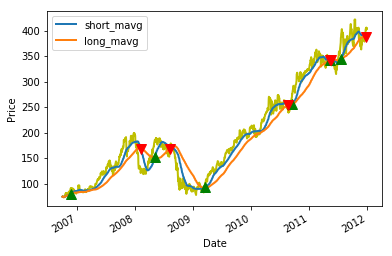

In [30]:
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel = 'Price')

# Plot the closing prices
apple_ticker_data['Close'].plot(ax=ax1, color = 'y', lw=2)

# Plot the short and long moving average
signals[['short_mavg','long_mavg']].plot(ax=ax1, lw=2)

# Plot the buy signal
ax1.plot(signals.loc[signals.position == 1.0].index,
         signals.short_mavg[signals.position == 1.0], 
         marker = '^', markersize = 10, color='g', lw=0)

# Plot the sell signal
ax1.plot(signals.loc[signals.position == -1.0].index,
         signals.short_mavg[signals.position == -1.0], 
         marker = 'v', markersize = 10, color='r', lw=0)

plt.show()

### 4. Backtesting the SMA cross-over strategy

In [31]:
# Simple Backtester

# Initial capital
initial_capital = 100000

# Positions Dataframe
positions = pd.DataFrame(index = signals.index)

# Buy 100 shares
positions['AAPL'] = 100 * signals['signal']

# Initialize the portfolio with values of shares owned
portfolio = positions.multiply(apple_ticker_data['Adj. Close'], axis=0)

# Stores the difference in shares owned
pos_diff = positions.diff()

# Add holdings to portfolio
portfolio['holdings'] = (positions.multiply(apple_ticker_data['Adj. Close'], axis=0)).sum(axis=1)

# Add cash to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(apple_ticker_data['Adj. Close'], axis=0)).sum(axis=1).cumsum()

# Total portfolio worth
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# portfolio returns
portfolio['returns'] = portfolio['total'].pct_change()
print(portfolio.tail())

                   AAPL     holdings           cash          total   returns
Date                                                                        
2011-12-23  5183.352647  5183.352647   97695.616584  102878.969231  0.000597
2011-12-27     0.000000     0.000000  102920.093691  102920.093691  0.000400
2011-12-28     0.000000     0.000000  102920.093691  102920.093691  0.000000
2011-12-29     0.000000     0.000000  102920.093691  102920.093691  0.000000
2011-12-30     0.000000     0.000000  102920.093691  102920.093691  0.000000


### 5. Visualizing portfolio constructed during backtesting using SMA cross-over strategy

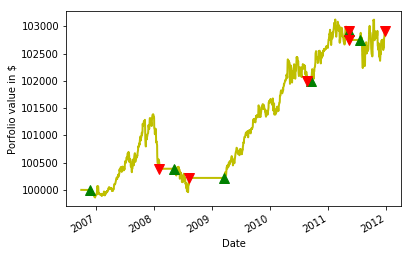

In [32]:
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel = "Porfolio value in $")

portfolio['total'].plot(ax = ax1, color = 'y', lw=2.0)

# Plot the portfolio on buy signal
ax1.plot(portfolio.loc[signals.position == 1.0].index,
         portfolio.total[signals.position == 1.0], 
         marker = '^', markersize = 10, color='g', lw=0)

# Plot the portfolio on sell signal
ax1.plot(portfolio.loc[signals.position == -1.0].index,
         portfolio.total[signals.position == -1.0], 
         marker = 'v', markersize = 10, color='r', lw=0)


### 6. Evaluating performance of SMA cross-over strategy

#### A. Sharpe Ratio

In [33]:
returns = portfolio['returns']

# annualized sharpe ratio
sharpe_ratio = np.sqrt(252)*(returns.mean()/returns.std())

print(sharpe_ratio)

0.726123882587035


#### B. Compound Annualized Growth Rate - CAGR

In [34]:
days = (apple_ticker_data.index[-1]-apple_ticker_data.index[0]).days
cagr = apple_ticker_data['Adj. Close'][-1] - apple_ticker_data['Adj. Close'][1]
cagr **= (365.0/days)
cagr -= 1
print(cagr)

1.043753306250188


### 7. Implementing SMA Algorithm in Quantopian

Algorithm
1. If we have enough cash, buy 100 shares if short-period moving average price is greater than long-period moving average price
2. Sell all shares if short-period moving average priceis less than long-period moving average price, inorder to realize profits

In [2]:
def initialize(context):
    context.sym = symbol('AAPL')
    context.i = 0
    
def handle_data(context, data):
    # skip first 300 days to get full windows
    context.i += 1
    if context.i < 300:
        return
    # Calculate short and long moving averages
    short_mavg = data.history(context.sym, 'price', 100, '1d').mean()
    long_mavg = data.history(context.sym, 'price', 300, '1d').mean()
    
    # Buy quantity per min
    buy_quantity = 100
    
    # Trading logic
    # If we have enough cash,
    # Buy 100 shares if short-period moving average price
    # is greater than long-period moving average price
   
    have_enough_cash = context.portfolio.cash >= buy_quantity * data.current(context.sym, 'price')
    if have_enough_cash and short_mavg > long_mavg:
        order(context.sym, buy_quantity)
        
    # Sell all shares if short-period moving average price
    # is less than long-period moving average price
    # inorder to realize profit in terms of cash.
    elif short_mavg < long_mavg:
        order_target(context.sym, 0)
        
    # Save above transaction
    record(AAPL=data.current(context.sym, 'price'),
           short_mavg = short_mavg,
           long_mavg = long_mavg)

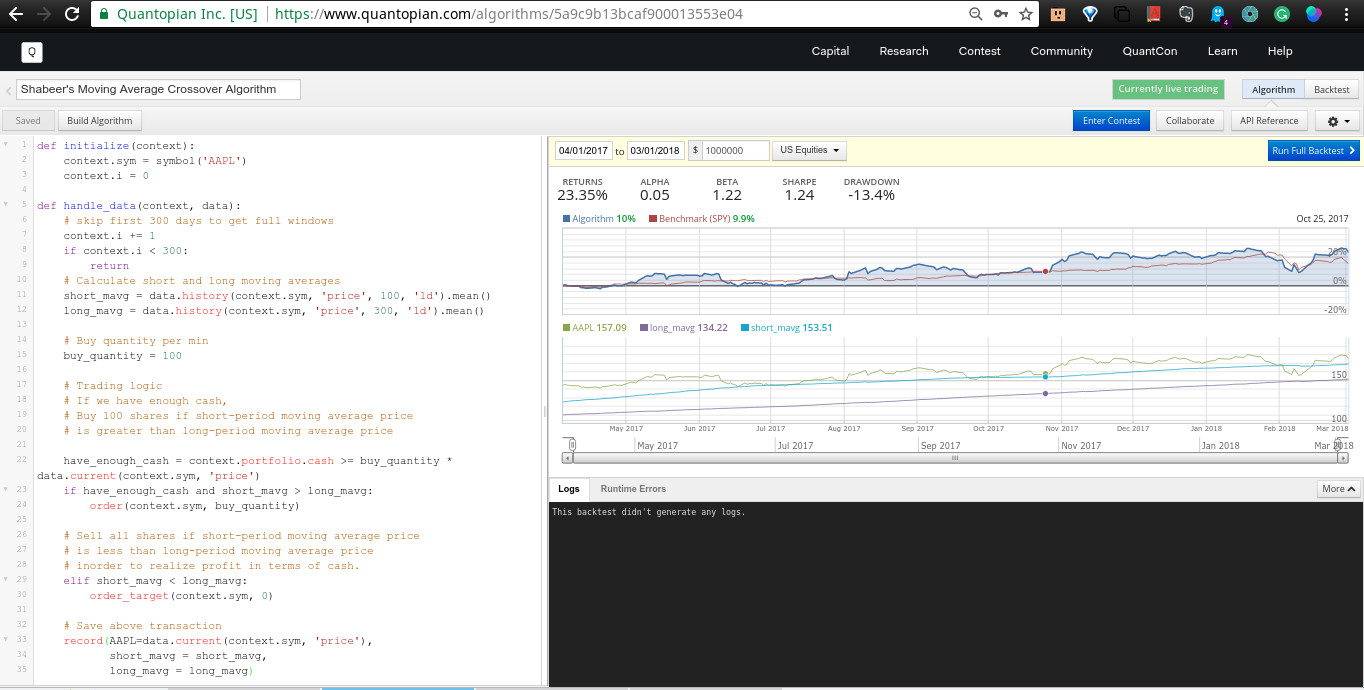

In [5]:
from IPython.display import Image
Image(filename="Moving_avg_crossover_Algorithm_in_Quantopian.jpg")

### 8. Backtest SMA strategy on Quantopian

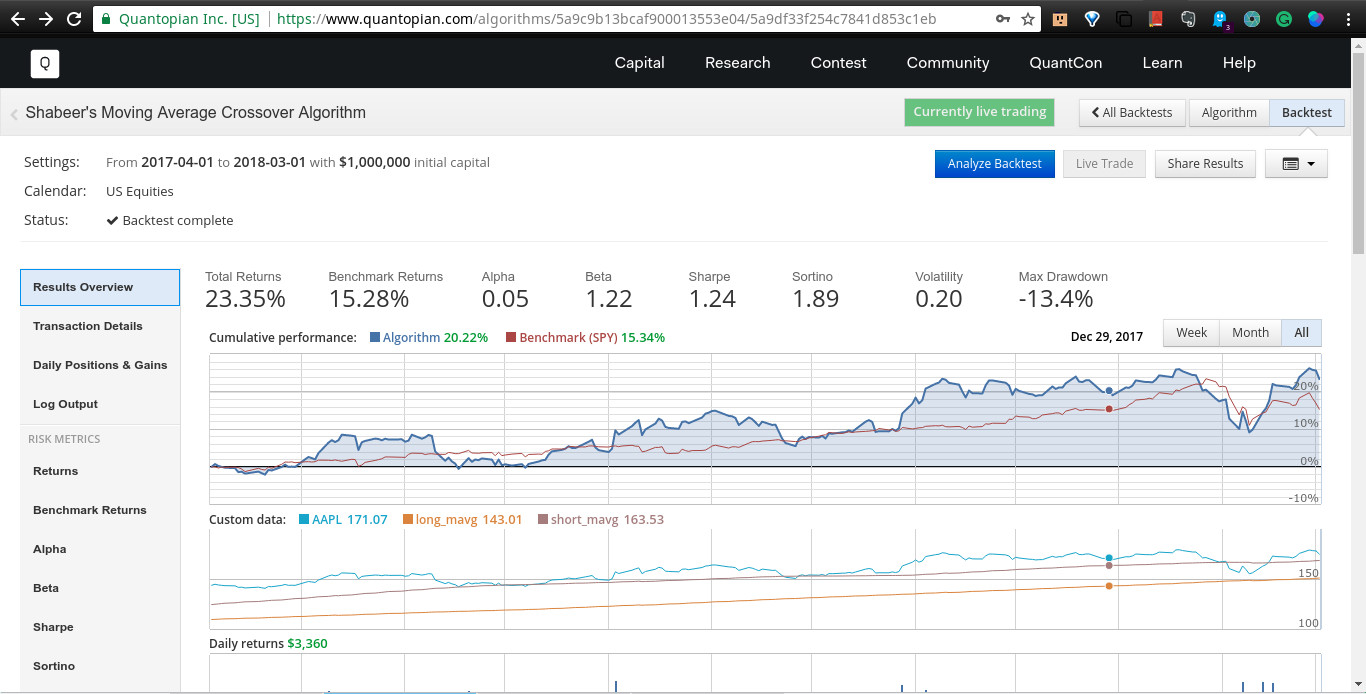

In [6]:
from IPython.display import Image
Image(filename="Moving_avg_crossover_quantopian_backtesting_results.jpg")

### 9. Backtesting - Performance Results
1. Returns by SMA algorithm is 23.34% compared to benchmark of only 15.34%
2. Alpha: 0.05 (low since trading in only in Apple stocks - less diversified)
3. Beta: 1.22
4. Sharpe: 1.24
5. Sortino:  1.89
6. Max Drawdown: -13.4%